## Часть 2. Добавление полиномиальных признаков

In [9]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
from sklearn.datasets import load_boston

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split

x_scaler = StandardScaler()
y_scaler = StandardScaler()

In [2]:
boston = load_boston()
data = pd.DataFrame(data=boston["data"][boston['target'] < 50], columns=boston["feature_names"])
data["MEDV"] = boston["target"][boston['target'] < 50]
y = data["MEDV"]

In [3]:
poly = PolynomialFeatures(degree=4)
X = poly.fit_transform(data[['RM', 'LSTAT']])

In [4]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X, y, test_size = 0.33, random_state = 18)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test.values.reshape(-1, 1))

In [5]:
X_scaled = x_scaler.fit_transform(data[['LSTAT']])
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
X_poly_scaled = x_scaler.fit_transform(X)

In [6]:
model = SGDRegressor(
    loss='squared_loss',
    penalty='l1',
    alpha=0.01,
    learning_rate='constant',
    max_iter=np.ceil(10**6 / len(X_train)),
    eta0=0.0005 # added 0 to reduce huge error
)
model.fit(X_train, Y_train.ravel())
Y_pred = model.predict(X_test)

In [124]:
# LinearRegression(), no scaling
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(14.207057877018034, 0.8010349857129089)

In [149]:
# st-scaled sgdregressor
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(0.2582309912036412, 0.7951224636148099)

In [7]:
predictions = model.coef_ @ X_poly_scaled.T + model.intercept_

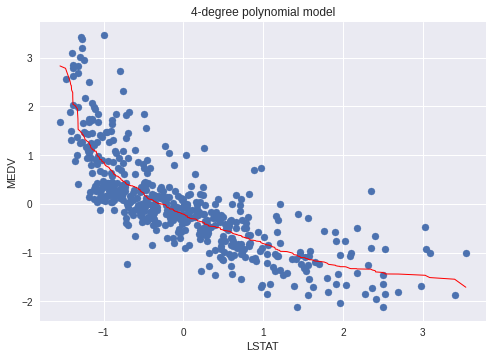

In [15]:
plt.scatter(X_scaled, y_scaled)
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.title('4-degree polynomial model')
plt.plot(sorted(X_scaled), sorted(predictions.reshape(490,), reverse=True), lw=1, c='r');

#### considering the r squared error is ~0.8, the model overfits the data

In [254]:
def curve(X_scaled, y_scaled, title):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator = SGDRegressor(
            loss='squared_loss',
            penalty='l1',
            alpha=0.01,
            learning_rate='constant',
            max_iter=np.ceil(10**6 / len(X_scaled)),
            eta0=0.0005 # added 0 to reduce huge error
            ),
        X = X_scaled,
        y = y_scaled.ravel(),
        train_sizes = [1, 25, 75, 150, 250, 392],
        cv = 7,
        shuffle = True,
        scoring = 'neg_mean_squared_error')

    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()

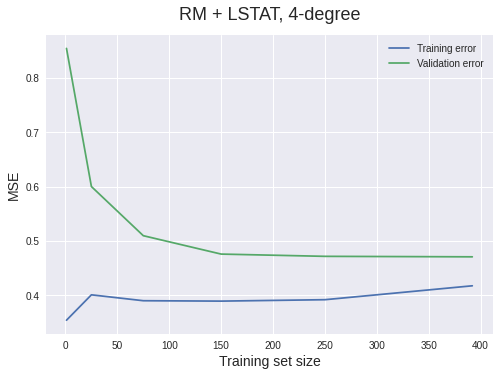

In [262]:
curve(X_scaled, y_scaled, 'RM + LSTAT, 4-degree')

#### low bias, high variance (as noticed in the 1st part): low TE and large gap (no convergence) -> we probably need more samples

## Подбираем признаки и степень

In [13]:
class PolySGDR:
    
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        
    def make(self, features, degree, y=data['MEDV']):
        self.features = features
        self.degree = degree
        self.y = y
        poly = PolynomialFeatures(self.degree)
        X = poly.fit_transform(self.features)
        X_train, X_test, Y_train, Y_test =\
            train_test_split(X, self.y, test_size = 0.33, random_state = 18)
        X_train = x_scaler.fit_transform(X_train)
        Y_train = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
        X_test = x_scaler.transform(X_test)
        Y_test = y_scaler.transform(Y_test.values.reshape(-1, 1))
        self.y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
        self.X_poly_scaled = x_scaler.fit_transform(X)

        self.model = SGDRegressor(
        loss='squared_loss',
        penalty='l1',
        alpha=self.alpha,
        learning_rate='constant',
        max_iter=np.ceil(10**6 / len(X_train)),
        eta0=0.0005 # added 0 to reduce huge error
        )
        self.model.fit(X_train, Y_train.ravel())
        Y_pred = self.model.predict(X_test)

        self.mse = mean_squared_error(Y_test, Y_pred)
        self.r_squared = r2_score(Y_test, Y_pred)
        self.predictions = self.model.coef_ @ self.X_poly_scaled.T + self.model.intercept_

    def plot(self, spec_feature, xlabel):
        X_scaled = x_scaler.fit_transform(spec_feature)
        plt.scatter(X_scaled, self.y_scaled)
        plt.xlabel(xlabel)
        plt.ylabel('MEDV')
        plt.title(f'{self.features.columns}, {self.degree}-degree')
        plt.plot(sorted(X_scaled), sorted(self.predictions.reshape(490,), reverse=True), c='r');
        
    def curve(self, title):
        train_sizes, train_scores, validation_scores = learning_curve(
            estimator = self.model,
            X = self.X_poly_scaled,
            y = self.y_scaled.ravel(),
            train_sizes = [1, 25, 75, 150, 250, 392],
            cv = 7,
            shuffle = True,
            scoring = 'neg_mean_squared_error')

        train_scores_mean = -train_scores.mean(axis = 1)
        validation_scores_mean = -validation_scores.mean(axis = 1)

        plt.plot(train_sizes, train_scores_mean, label = 'Training error')
        plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
        plt.ylabel('MSE', fontsize = 14)
        plt.xlabel('Training set size', fontsize = 14)
        plt.title(title, fontsize = 18, y = 1.03)
        plt.legend()

In [14]:
model1 = PolySGDR(alpha=0.1)
model1.make(features=data[['RM', 'LSTAT']], degree=2)

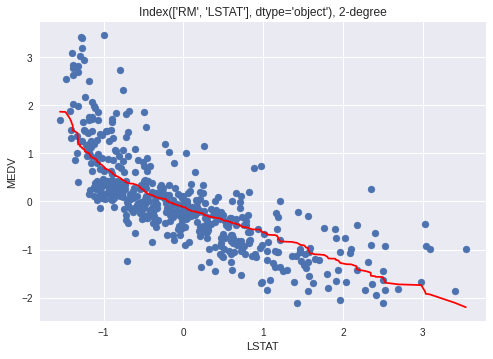

In [15]:
model1.plot(data[['LSTAT']], 'LSTAT')

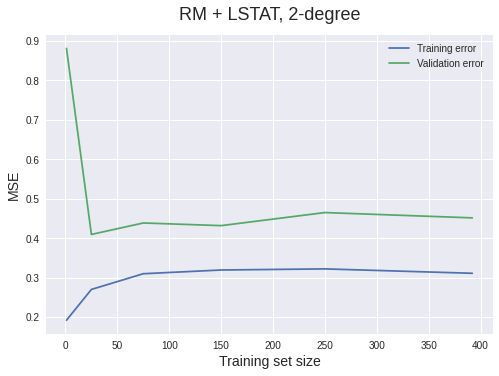

In [16]:
model1.curve('RM + LSTAT, 2-degree')

In [17]:
model1.mse, model1.r_squared

(0.34812305946408045, 0.7238031173197536)

#### the gap is still wide, the curves remain the same overall, the R2 was reduced down to 0.72

In [18]:
model2 = PolySGDR(alpha=0.1)
model2.make(features=data[['LSTAT']], degree=2)

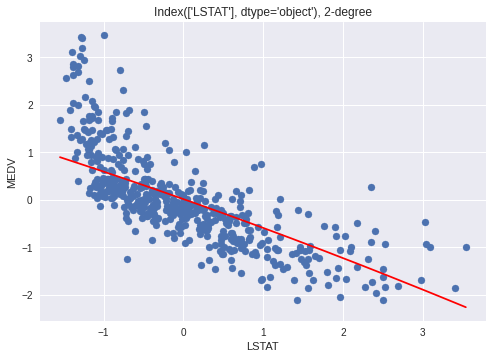

In [19]:
model2.plot(data[['LSTAT']], 'LSTAT')

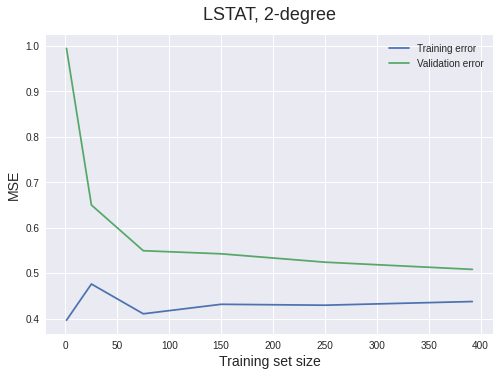

In [21]:
model2.curve('LSTAT, 2-degree')

In [22]:
model2.mse, model2.r_squared

(0.5477728386095791, 0.5654032494320129)

#### the plot is basically a line, the gap between the curves is more narrow, but the r_squared is down to 0.54 now

In [23]:
model3 = PolySGDR(alpha=0.1)
model3.make(features=data[['RM']], degree=2)

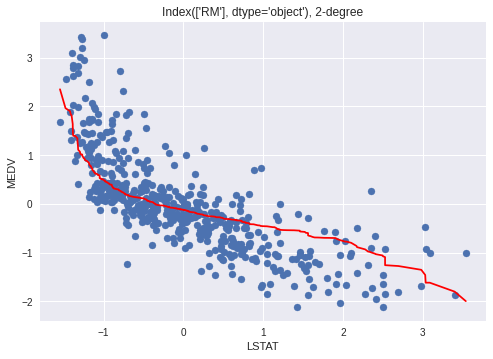

In [25]:
model3.plot(data[['LSTAT']], 'LSTAT')

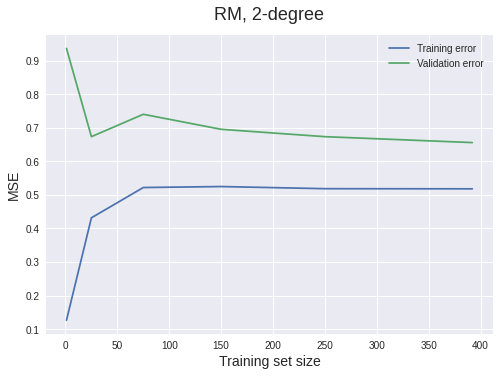

In [27]:
model3.curve('RM, 2-degree')

In [28]:
model3.mse, model3.r_squared

(0.5894855465538628, 0.5323088605682054)

#### the gap is too wide and the R2 is still low; the curves are worse than usual (too high error)

In [29]:
model4 = PolySGDR(alpha=0.1)
model4.make(features=data[['LSTAT']], degree=3)

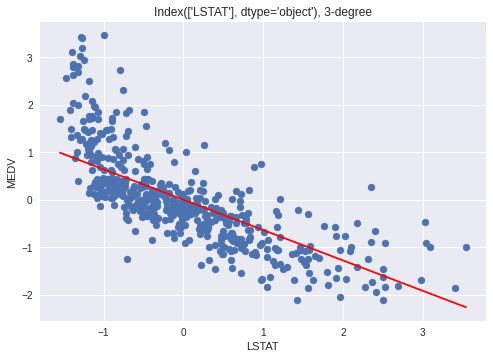

In [30]:
model4.plot(data[['LSTAT']], 'LSTAT')

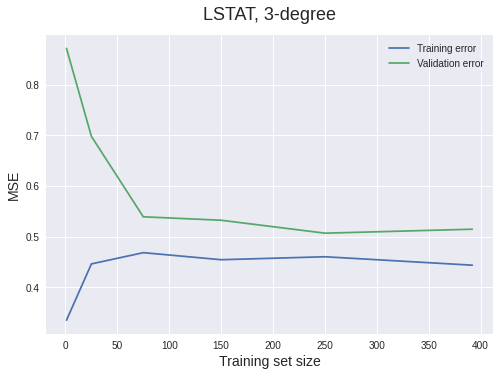

In [32]:
model4.curve('LSTAT, 3-degree')

In [33]:
model4.mse, model4.r_squared

(0.5209106476745399, 0.5867154067181204)

#### a little bit better combination of the learning curves and the R2

In [34]:
model5 = PolySGDR(alpha=0.1)
model5.make(features=data[['RM']], degree=3)

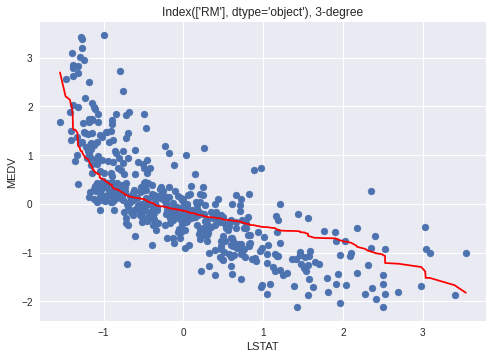

In [36]:
model5.plot(data[['LSTAT']], 'LSTAT')

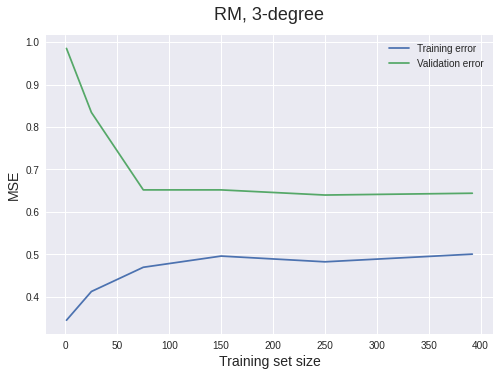

In [39]:
model5.curve('RM, 3-degree')

In [40]:
model5.mse, model5.r_squared

(0.5668155502544874, 0.5502949782298716)

### all models based on any degree of RM feature show high training and validation error; LSTAT feature does not describe the data well enough (there is a low training error hence low bias); let's try using more features

In [46]:
model7 = PolySGDR(alpha=0.1)
model7.make(features=data[['RM', 'LSTAT', 'PTRATIO', 'ZN']], degree=2)

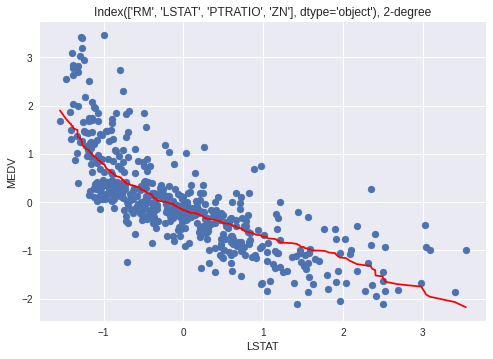

In [47]:
model7.plot(data[['LSTAT']], 'LSTAT')

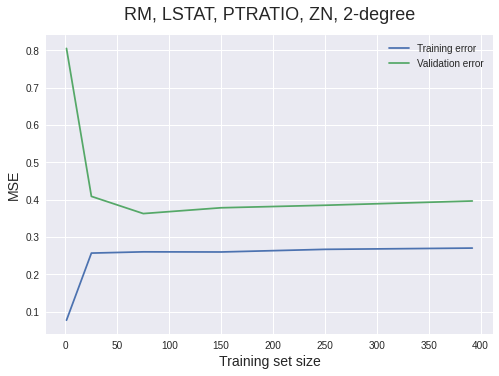

In [60]:
model7.curve('RM, LSTAT, PTRATIO, ZN, 2-degree')

In [49]:
model7.mse, model7.r_squared

(0.3216014389875435, 0.7448450698710292)

In [81]:
model8 = PolySGDR(alpha=0.1)
model8.make(features=data[['RM', 'LSTAT', 'PTRATIO', 'ZN']], degree=4)

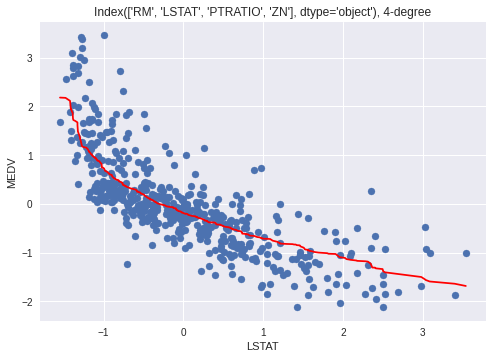

In [82]:
model8.plot(data[['LSTAT']], 'LSTAT')

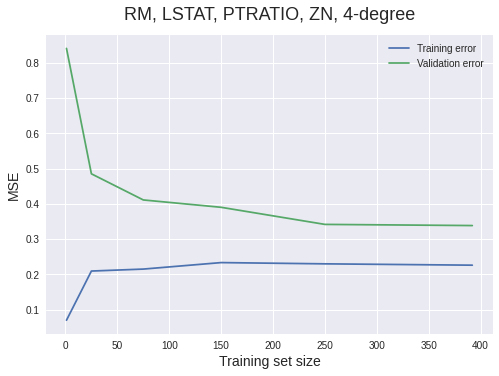

In [83]:
model8.curve('RM, LSTAT, PTRATIO, ZN, 4-degree')

In [84]:
model8.mse, model8.r_squared

(0.26724240534553967, 0.7879729099530541)

In [85]:
model9 = PolySGDR(alpha=0.1)
model9.make(features=data[['RM', 'LSTAT', 'PTRATIO', 'ZN']], degree=7)

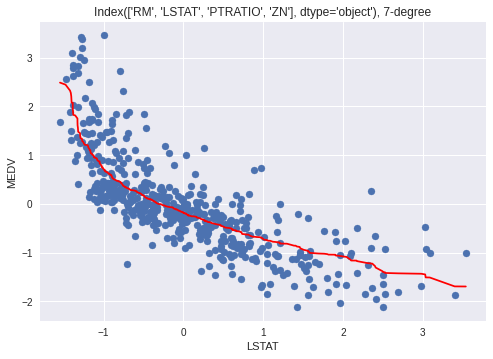

In [86]:
model9.plot(data[['LSTAT']], 'LSTAT')

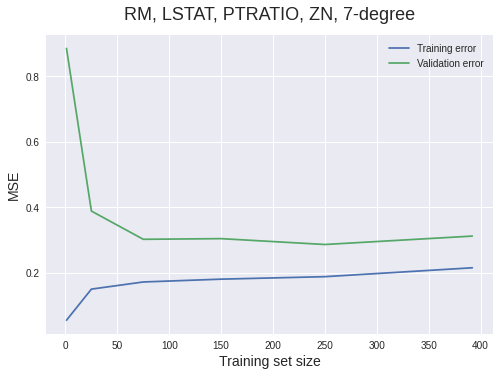

In [89]:
model9.curve('RM, LSTAT, PTRATIO, ZN, 7-degree')

In [90]:
model9.mse, model9.r_squared

(0.2519684940415446, 0.8000910577568576)

### Закономерно, чем выше степень, тем лучше модель описывает данные. Тем не менее, на данном этапе нам достаточно полинома 4 степени для четырех признаков, лучше всего коррелирующих с ценой жилья (при повышении степени коэффициент детерминации остается на уровне ~0.8); при уменьшающейся ошибке мы наблюдаем достаточно сбалансированные кривые